In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, Add, Activation, concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [4]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1098839523.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


In [7]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [8]:
def residual_block(x, filters, kernel_size):
    shortcut = x
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

In [9]:
inputs = Input(shape=(n_timesteps, n_features))

# Level 1
conv1 = Conv1D(128, 3, activation='relu')(inputs)
conv1 = residual_block(conv1, 128, 3)
pool1 = MaxPooling1D(2)(conv1)

# Level 2
conv2 = Conv1D(64, 3, activation='relu')(pool1)
conv2 = residual_block(conv2, 64, 3)
pool2 = MaxPooling1D(2)(conv2)

# Level 3
conv3 = Conv1D(32, 3, activation='relu')(pool2)
conv3 = residual_block(conv3, 32, 3)
pool3 = MaxPooling1D(2)(conv3)

# Flatten + Dense
flat = Flatten()(pool3)
dense = Dense(512, activation='relu')(flat)
outputs = Dense(n_outputs, activation='softmax')(dense)

cnn_resnet_model = Model(inputs, outputs)
cnn_resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 128)  │      3,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 126, 128)  │     49,280 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 126, 128)  │     49,280 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 126, 128)  │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 126, 128)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 63, 128)   │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 61, 64)    │     24,640 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 61, 64)    │     12,352 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 61, 64)    │     12,352 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 61, 64)    │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 64)    │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 30, 64)    │          0 │ activation_1[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 28, 32)    │      6,176 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 28, 32)    │      3,104 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 28, 32)    │      3,104 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 28, 32)    │          0 │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 32)    │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 14, 32)    │          0 │ activation_2[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 448)       │          0 │ max_pooling1d_2[

 Total params: 396,838 (1.51 MB)

 Trainable params: 396,838 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_history = cnn_resnet_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.6892 - loss: 0.7449 - val_accuracy: 0.9406 - val_loss: 0.1116
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9421 - loss: 0.1582 - val_accuracy: 0.9457 - val_loss: 0.1107
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9476 - loss: 0.1228 - val_accuracy: 0.9287 - val_loss: 0.2200
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9475 - loss: 0.1295 - val_accuracy: 0.9508 - val_loss: 0.1039
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9473 - loss: 0.1168 - val_accuracy: 0.9406 - val_loss: 0.1109
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9407 - loss: 0.1566 - val_accuracy: 0.9491 - val_loss: 0.1058
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9508 - loss: 0.1169 - val_accuracy: 0.9576 - val_loss: 0.1004
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - accuracy: 0.9540 - loss: 0.1177 - 

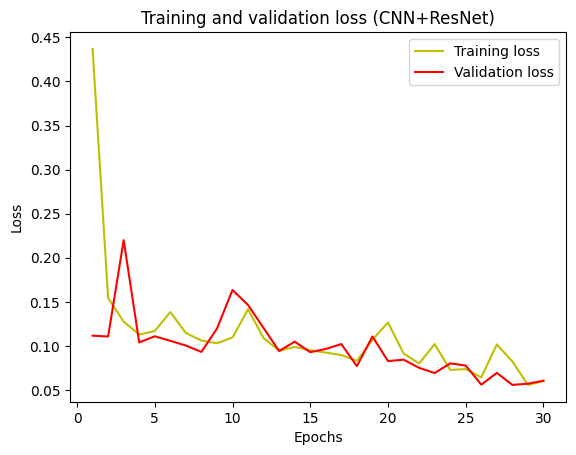

In [11]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (CNN+ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

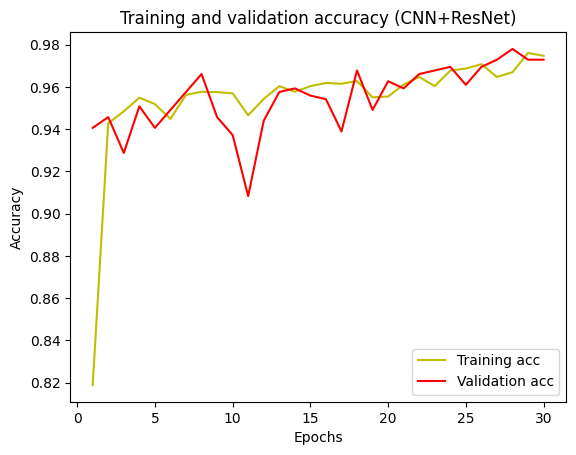

In [12]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (CNN+ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
[[472   0  18   6   0   0]
 [ 12 430  27   2   0   0]
 [  1   2 417   0   0   0]
 [  0   7   0 415  64   5]
 [  0   2   0  88 442   0]
 [  0   0   0   0   0 537]]
0.9205972175093315
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       496
           1       0.98      0.91      0.94       471
           2       0.90      0.99      0.95       420
           3       0.81      0.85      0.83       491
           4       0.87      0.83      0.85       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

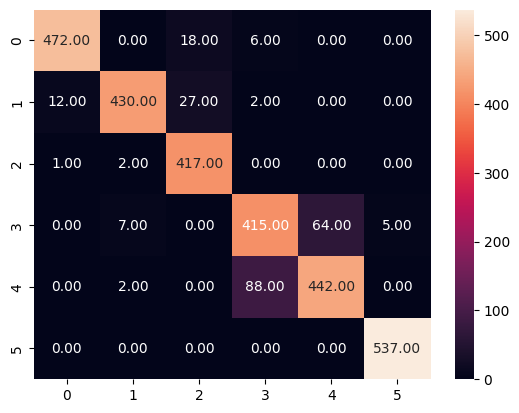

In [13]:
pred = cnn_resnet_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')